In [2]:
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from chemical_space import ChemicalSpace
import matplotlib.lines as mlines
import matplotlib as mpl
import pickle
import seaborn as sns

In [3]:
aryl_scope = ChemicalSpace(['ligand_name'], ['electrophile_id', 'nucleophile_id'], 'datasets/real_datasets/aryl-scope-ligand.csv')
aryl_scope.titles = ['Ligand', 'Electrophile', 'Nucleophile']
aryl_scope.dataset_name = "Pd-Aryl"
borylation = ChemicalSpace(['ligand_name', 'solvent'], ['electrophile_id'], 'datasets/real_datasets/borylation.csv')
borylation.titles = ['Ligand', 'Solvent', 'Electrophile']
borylation.dataset_name = "Ni-Boryl"
deoxy = ChemicalSpace(['base_name', 'fluoride_name'], ['substrate_name'], 'datasets/real_datasets/deoxyf.csv')
deoxy.titles = ['Base', 'Fluoride', 'Substrate']
deoxy.dataset_name = "DeoxyF"
buchwald_hartwig = ChemicalSpace(['Catalyst','Solvent','Base'], ['Amine','Bromide'], 'datasets/real_datasets/buchwald-hartwig.csv')
buchwald_hartwig.dataset_name = "B-H"

In [4]:
def plot_set_coverages(chemical_space:ChemicalSpace, set_sizes:list, cutoff:float, show_legend = True, font_size=15, bins=None, xmin=None)->None:
        coverages = []
        plt.rcParams['font.family'] = "sans-serif"
        plt.rcParams['font.sans-serif'] = "Arial"
        for size in set_sizes:
            conditions = itertools.combinations(chemical_space.all_conditions, size)
            covs = [chemical_space.yield_surface.count_coverage(condition, cutoff)*100 for condition in conditions]
            print(f"{size} max cov: {np.array(covs).max()}")
            coverages.append(covs) 
        # create custom matplot lib color map
        cmap = ListedColormap(['#FF1F5B', '#009ADE', '#AF58BA', '#FFC61E', '#F28522', '#00CD6C'])
        plt.set_cmap(cmap)
        print(coverages)
        if bins is None:
            bins = np.prod(chemical_space.shape[chemical_space.conditions_dim:])
        if xmin:
            coverages = [[n for n in c if n >= xmin] for c in coverages]
        plt.hist(coverages, bins=bins, histtype='bar', label=[f"{size}" for size in set_sizes], stacked=False, log = True, color=['#FF1F5B', '#009ADE', '#AF58BA', '#FFC61E', '#F28522', '#00CD6C'][:len(set_sizes)])
        plt.xlabel('Coverage of Reactant Space (%)', fontsize=font_size)
        plt.ylabel('Number of Sets', fontsize=font_size)
        plt.tick_params(axis='both', which='major', labelsize=13)
        if show_legend:
            #loc='center left', bbox_to_anchor=(1, 0.5),loc='upper left'
            plt.legend(title='Number of Reaction \nConditions in a Set', loc='center left', bbox_to_anchor=(1, 0.5),  fontsize=11, title_fontsize=13)
        plt.savefig("./histogram.png")
        plt.show(block=True)
        # plt.title('Reaction Space Coverage Distribution over Condition Sets', fontsize=font_size)

In [ ]:
plot_set_coverages(aryl_scope, [1,2,3, 4, 5], 21.66, bins=24)

In [ ]:
# plot_set_coverages(borylation, [1,2,3, 4, 5, 6], 77.24, bins=26)

In [ ]:
plot_set_coverages(deoxy, [1,2,3, 4, 5], 50, bins=21, xmin=20)

In [ ]:
plot_set_coverages(deoxy, [1,2,3, 4], 50, bins=14, xmin=40)

In [4]:
plot_set_coverages(buchwald_hartwig, [1,2,3, 4], 26.89, bins=67)

In [ ]:
plot_set_coverages(buchwald_hartwig, [1,2,3, 4], 26.89, bins=22)

In [4]:
def compare_spaces(spaces:list[ChemicalSpace])->None:
    colors = ['#FF1F5B', '#009ADE', '#AF58BA', '#FFC61E', '#F28522']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6)) #ax1, ax2, ax0, ax3
    for n, cs in enumerate(spaces):
        yields, coverage = cs.get_yield_coverage()
        # all_yields, successful_rxns = cs.get_yield_success()
        cond_yield, cond_coverage = cs.get_individual_conditions_coverage()
        diff = [0]*(len(yields)*2)
        diff_yield = [0]*(len(yields)*2)
        diff_total_cov = [0]*(len(yields)*2)
        j, k = 0, 0
        for i in range(len(diff)):
            if j >= len(cond_yield) or (k < len(yields) and yields[k] > cond_yield[j]):
                diff_yield[i] = yields[k]
                diff[i] = coverage[k] - cond_coverage[j-1]
                diff_total_cov[i] = coverage[k]
                k += 1
            else:
                diff_yield[i] = cond_yield[j]
                if k >= len(yields):
                    diff[i] = 1 - cond_coverage[j]
                    diff_total_cov[i] = 1
                else:
                    diff[i] = coverage[k] - cond_coverage[j]
                    diff_total_cov[i] = coverage[k]
                j += 1
        # ax0.plot(diff_yield, diff, label=cs.dataset_name)
        ax1.plot(yields, np.array(coverage) * 100, label=cs.dataset_name, color = colors[n])
        ax1.plot(cond_yield, np.array(cond_coverage) * 100, label=cs.dataset_name, linestyle='dashed', color = colors[n])
        ax2.plot(diff_yield, np.array(diff) *100, label=cs.dataset_name, color = colors[n])
    ax1.set_xlabel('Yield Cutoff', fontsize=20)
    ax1.set_ylabel('Coverage of Reactant Space (%)', fontsize=20)
    dashed_patch = mlines.Line2D([],[],color='black', linestyle='dashed', label='Top Individual Condition')
    solid_patch = mlines.Line2D([],[],color='black', label='All Conditions')
    ax1.legend(handles=[solid_patch, dashed_patch], loc='lower left',fontsize=13)
    ax2.set_xlabel('Yield Cutoff', fontsize=20)
    ax2.set_ylabel('Individual Condition Coverage Gap (Δ)', fontsize=20)
    ax2.legend(fontsize=13, loc='upper left')
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    ax1.annotate('',
        xytext=(62, 70),
        xy=(62, 90),
        arrowprops=dict(arrowstyle="->", color='black'),
        # size=size
    )
    ax1.annotate('Δ',
        xytext=(64, 77),
        xy=(64, 77)
    )
    plt.show()

In [ ]:
compare_spaces([aryl_scope, borylation, deoxy, buchwald_hartwig])

In [5]:
def plot_subset_overlap(chemical_space:ChemicalSpace, set_size:int, cutoff:float, max_num_sets=None, vmin=100, vmax = 0, font_size = 15, cond_cutoff=None, cov_min=0, cov_max=75)->None:
        fig = plt.figure(figsize=(6.5, 8.805))
        gs = fig.add_gridspec(1, 2, width_ratios=[3.6, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1) #

        if max_num_sets is None:
             max_num_sets = len(chemical_space.all_conditions)

        individual = chemical_space.best_condition_sets(cutoff, 1, None)
        # ordered_conds, coverage 
        conds_condensed = [cond[0] for cond in individual['set']]
        sets = chemical_space.best_condition_sets(cutoff, set_size, max_num_sets)
        conds_over_ys = []
        conds_over_txt = []
        if cond_cutoff is None:
            combination_mat = np.full((len(conds_condensed), max_num_sets), np.nan)
        else:
            combination_mat = np.full((cond_cutoff, max_num_sets), np.nan)
        f = lambda s: tuple(np.sort(np.array([-1*conds_condensed.index(c) for c in s]))[::-1])
        converted_sets = np.array([(f(s['set']), s['coverage'], -1*abs(s['size'])) for s in sets],dtype=[('set', 'O'), ('coverage', 'f4'),('size', 'i4')])
        converted_sets.sort(order=['coverage', 'size', 'set'])
        converted_sets = converted_sets[::-1]
        for i, set in enumerate(converted_sets['set']):
            for cond in set:
                idx = cond*-1
                if cond_cutoff is None or idx < cond_cutoff - 1:
                    combination_mat[idx][i] = individual[idx]['coverage']*100
                else:
                     conds_over_ys.append(i)
                     conds_over_txt.append(f'{idx+1}')
                     combination_mat[cond_cutoff - 1][i] = individual[idx]['coverage']*100

        sums = np.nansum(combination_mat, axis=1)
        trim_count = np.trim_zeros(sums, 'b')
        print(np.average(sets['size']))
        combination_mat = combination_mat[:len(trim_count) + 1]
        cmap = mpl.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
        cmap.set_bad('white', alpha=1)
        cmap.set_under('lightgray')
        cmap.name = 'vir_bad'
        try:
            plt.colormaps.register(cmap)
        except ValueError:
            pass
        plt.set_cmap(cmap)
        vmin = min(np.nanmin(combination_mat), vmin)
        vmax = max(sets['coverage'].max()*100, vmax)
        mat = ax1.imshow(combination_mat.T, aspect='auto', origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)
        ax1.set_xlabel('Ranked Individual Conditions', fontsize=font_size)
        ax1.set_ylabel(f'Ranked Condition Sets', fontsize=font_size)
        ticks = [0]
        ticks.extend(np.arange(4,combination_mat.shape[0], 5))
        ax1.set_xticks(ticks)
        labels = [f"{i + 1}" for i in ticks[:-1]]
        if cond_cutoff is None:
            labels.append(f'{ticks[-1]+1}')
        else:
            labels.append(f'{cond_cutoff}+')
        ax1.set_xticklabels(labels)
        ticks = [0]
        ticks.extend(np.arange(4,combination_mat.shape[1], 5))
        ax1.set_yticks(ticks)
        labels = [i + 1 for i in ticks]
        ax1.set_yticklabels(labels)
        for i, txt in enumerate(conds_over_txt):
            ax1.annotate(txt, (cond_cutoff - 1, conds_over_ys[i]), color='white', fontsize=8, ha='center', va='center')
        print(vmin)
        print(vmax)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        colors = cmap(norm(sets['coverage'] * 100))
        print(sets['coverage']*100)
        ax2.barh(range(len(sets)), sets['coverage']*100, color = colors)
        ax2.set_xlabel('Coverage (%)', fontsize=font_size)
        cax = plt.axes((0.05, 0.0, 0.9, 0.025))
        cbar = plt.colorbar(label='Coverage of Reactant Space (%)',cax= cax, ax=[ax1, ax2], mappable=mat, orientation="horizontal")
        cbar.ax.tick_params(labelsize=13)
        cbar.ax.set_xlabel('Coverage of Reactant Space (%)', fontsize=font_size)
        ax2.set_xbound(cov_min,cov_max)
        ax1.set_xticks(np.arange(-.5, combination_mat.shape[0], 1), minor=True)
        ax1.set_yticks(np.arange(-.5, combination_mat.shape[1], 1), minor=True)
        ax1.tick_params(which='minor', length=0)
        ax2.tick_params(which='minor', length=0)
        ax1.grid(color='lightgray', which='minor', linestyle='-', linewidth=0.5)
        ax1.tick_params(axis='both', which='major', labelsize=13)
        ax2.tick_params(axis='both', which='major', labelsize=13)
        dark_ticks = []
        for i in range(1, combination_mat.shape[1]):
            if sets[i]['coverage'] < sets[i-1]['coverage'] or sets[i]['size'] > sets[i-1]['size']:
                dark_ticks.append(i-.5)
                ax1.hlines(i-.5, xmin=-.5, xmax=combination_mat.shape[0] - .5, colors='black', linestyles='-', linewidth=.5)
        plt.savefig("./set_components.png")
        plt.show(block=True)


2.871794871794872
6.060606241226196
63.63636255264282
[63.636364 60.606064 60.606064 60.606064 60.606064 60.606064 60.606064
 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756
 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756
 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756
 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756 57.575756
 57.575756 57.575756 57.575756 54.545456]


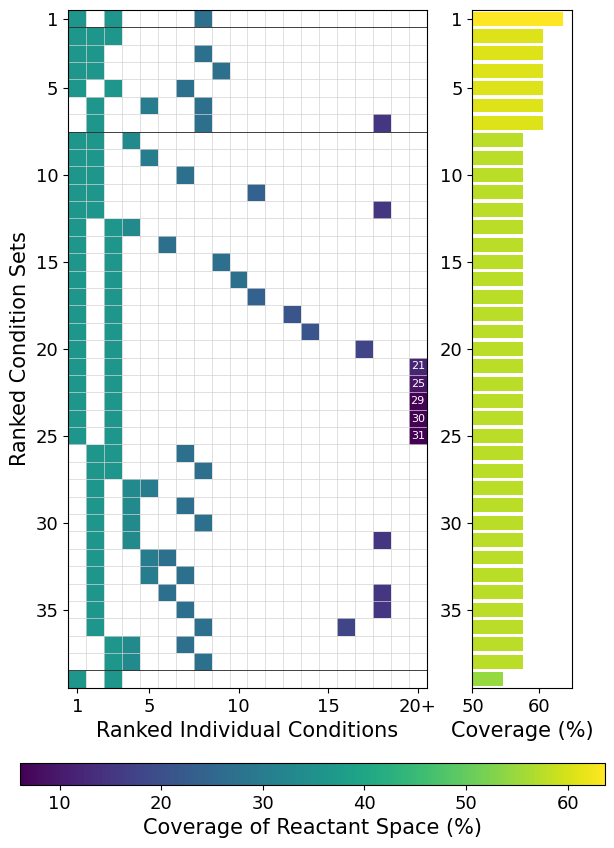

In [24]:
plot_subset_overlap(borylation, 3, 77.24, 39, cov_min=50, cond_cutoff=20, cov_max=65)

2.2857142857142856
32.43243098258972
75.67567825317383
[75.675674 75.675674 72.97297  72.97297  72.97297  72.97297  72.97297
 72.97297  72.97297  72.97297  72.97297  70.27027  70.27027  70.27027
 70.27027  70.27027  70.27027  70.27027  70.27027  70.27027  70.27027
 70.27027  70.27027  70.27027  70.27027  70.27027  70.27027  70.27027 ]


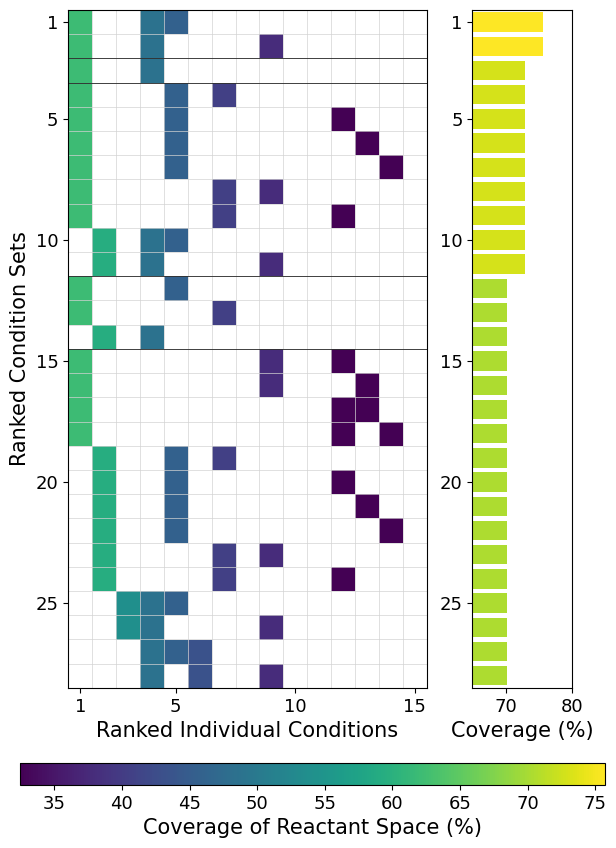

In [21]:
plot_subset_overlap(deoxy, 3, 50, max_num_sets=28, cov_min=65, cov_max=80)

2.732142857142857
17.1875
76.5625
[76.5625 76.5625 75.     75.     75.     75.     75.     75.     75.
 75.     75.     75.     75.     75.     75.     75.     75.     75.
 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375
 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375
 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375
 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375 73.4375
 73.4375 73.4375]


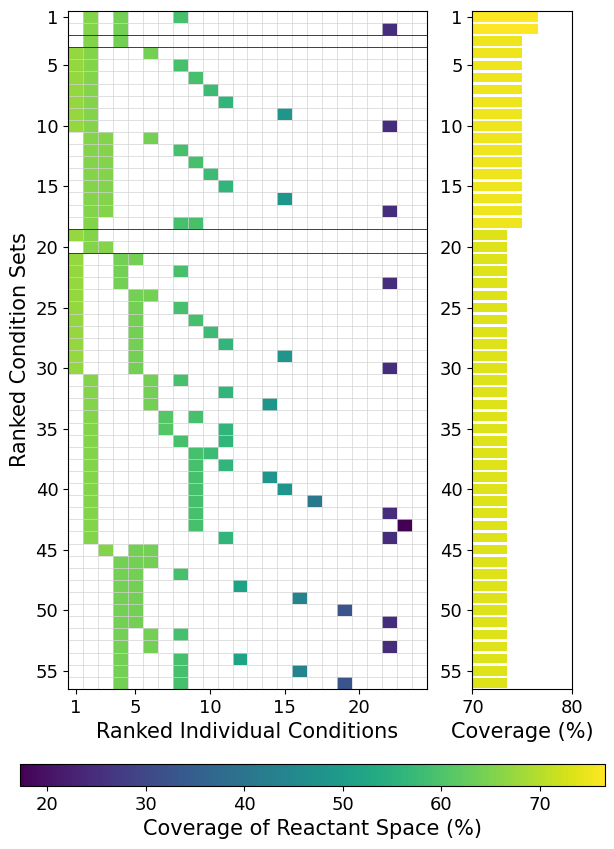

In [22]:
plot_subset_overlap(aryl_scope, 3, 21.66, max_num_sets=56, cov_min=70, cov_max=80)

3.0
33.079999685287476
72.9200005531311
[72.92     72.84     72.64     72.399994 72.36     72.28     72.2
 72.119995 72.04     72.       71.92     71.92     71.84     71.8
 71.76     71.76     71.76     71.72     71.68     71.68     71.68
 71.68     71.68     71.68     71.64     71.64     71.64     71.56
 71.56     71.56     71.520004 71.520004 71.520004 71.48     71.48
 71.48     71.44     71.44     71.44     71.44     71.4      71.36
 71.36     71.32     71.32    ]


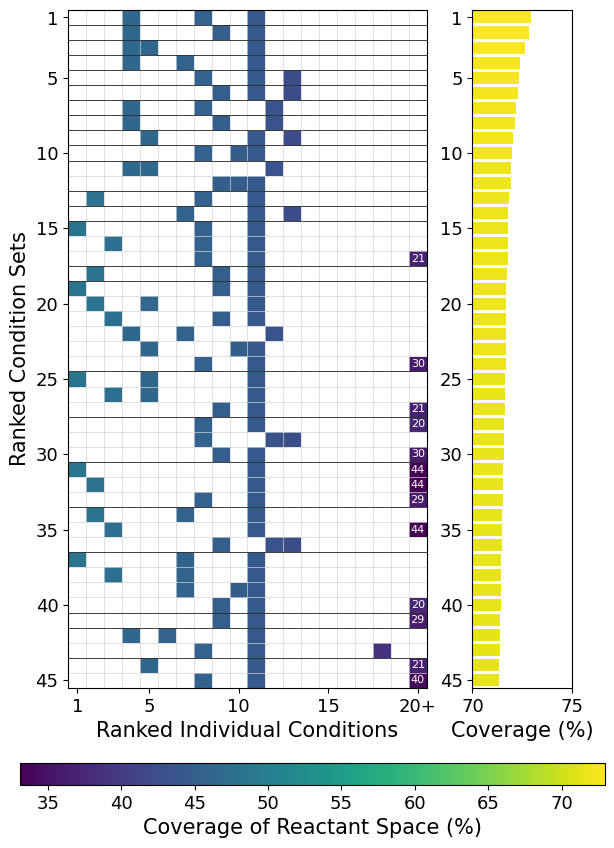

In [23]:
plot_subset_overlap(buchwald_hartwig, 3, 26.89, max_num_sets=45, cov_min=70, cov_max=75, cond_cutoff=20)

In [4]:
def plot_learner_metrics(chemical_space:ChemicalSpace, metric_filepaths:list, names:list, ax:plt.Axes, title:str, show_legend=True, colors=None, max_possible_set_cover=None)->None:
    assert len(metric_filepaths) == len(names), 'Number of filepaths and names must be the same'
    pred_covs = [f'Predicted Coverage' for i in range(len(names))]
    actual_covs = [f'Actual Coverage' for i in range(len(names))]
    config_file = metric_filepaths[0].replace('metrics_', 'config_')
    with open(config_file, 'rb') as f:
        try:
            config = pickle.load(f)
        except:
            print(config_file)
        max_set_size = config['max_set_size']
        yield_cutoff = config['cutoff']
    
    df = pd.DataFrame(columns=["Fraction of Space Tested", 'Predicted Coverage', 'Actual Coverage', 'Accuracy', 'Precision', 'Recall', 'name', 'pred_name', 'actual_name'])
    # accuracy, precision, recall = [], [], []
    m = {}
    for i, metric_file in enumerate(metric_filepaths):
        with open(metric_file, 'rb') as f:
            try:
                m = pickle.load(f)
            except:
                print(metric_file)
        conf_file = metric_file.replace('metrics_', 'config_')
        with open(conf_file, 'rb') as f:
            try:
                conf = pickle.load(f)
            except:
                print(config_file)
            batch_size = conf['batch_size']
            evals = np.divide([49 + i*batch_size for i in range(0, 1 + conf['max_experiments']//batch_size)], np.prod(chemical_space.shape)) *100
        for j, metric in m.items():
            
            # accuracy.append(metric['accuracy'])
            # precision.append(metric['precision'])
            # recall.append(metric['recall'])
            coverages = np.array(metric['coverages'])
            best_sets = metric['best_sets']
            best_3 = coverages[:,0]
            if np.any(best_3 > 1):
                best_3 = best_3/np.prod(chemical_space.shape[chemical_space.conditions_dim:])
            best_pred_sets = [s[0] for s in best_sets]
            best3_actual = [chemical_space.yield_surface.count_coverage(set, yield_cutoff) * 100 for set in best_pred_sets]
            # xs = np.arange(len(best_3))
            # set_ranks = [cond_to_rank_map[set] for set in best_pred_sets]
            # append to df
            # print(f'label {names[i]}')
            # print(len(evals[:len(best_3)]), len(best_3), len(best3_actual), len(set_ranks), len(metric['accuracy']), len(metric['precision']), len(metric['recall']))
            #iter_df = pd.DataFrame({'Fraction of Space Tested':evals[:len(best_3)], 'Predicted Coverage':best_3, 'Actual Coverage': best3_actual, 'Rank':set_ranks, 'Accuracy':metric['accuracy'], 'Precision':metric['precision'], 'Recall':metric['recall'], 'name':[names[i] for _ in range(len(best_3))], 'pred_name':[pred_covs[i] for _ in range(len(best_3))], 'actual_name':[actual_covs[i] for _ in range(len(best_3))]})
            iter_df = pd.DataFrame({'Fraction of Space Tested':evals[:len(best_3)], 'Predicted Coverage':best_3, 'Actual Coverage': best3_actual, 'Accuracy':metric['accuracy'], 'Precision':metric['precision'], 'Recall':metric['recall'], 'name':[names[i] for _ in range(len(best_3))], 'pred_name':[pred_covs[i] for _ in range(len(best_3))], 'actual_name':[actual_covs[i] for _ in range(len(best_3))]})
            iter_df.fillna(0, inplace=True)
            if df.empty:
                df  = iter_df
            else:
                df = pd.concat([df, iter_df])
    
    
    cov_labels = [""]*(len(pred_covs)*2)
    for i in range(len(pred_covs)):
        cov_labels[i*2] = pred_covs[i]
        cov_labels[i*2+1] = actual_covs[i]
    print(df.index.is_unique)
    # g = sns.lineplot(data=df, x='Fraction of Space Tested', y='Predicted Coverage', hue='pred_name', hue_order=pred_covs, ax=ax1)
    print(ax)
    g = sns.lineplot(data=df, x='Fraction of Space Tested', y='Actual Coverage', hue='name', hue_order=names, palette=colors, ax=ax)
    g.hlines(y=[chemical_space.max_possible_coverage(yield_cutoff)*100], xmin=df['Fraction of Space Tested'].min(), xmax=df['Fraction of Space Tested'].max(), colors='black', linestyles='solid')
    if max_possible_set_cover:
        g.hlines(y=[max_possible_set_cover*100], xmin=df['Fraction of Space Tested'].min(), xmax=df['Fraction of Space Tested'].max(), colors='gray', linestyles='solid')
    g.hlines(y=[chemical_space.best_condition_sets(yield_cutoff, 1, 1)[0]['coverage']*100], xmin=df['Fraction of Space Tested'].min(), xmax=df['Fraction of Space Tested'].max(), colors='black', linestyles='dashed')
    
    # g2 = sns.lineplot(data=df, x='Fraction of Space Tested', y='Rank', hue='name',palette=colors, ax=ax2)
    # g2.set_ylim(0, 110)
    ax.set_xlabel('Fraction of Space Tested (%)', fontsize=16)
    ax.set_ylabel('Coverage of Reactant Space (%)', fontsize=16)
    ax_handles, ax_labels = ax.get_legend_handles_labels()

    # loc='center left', bbox_to_anchor=(1, 0.5)
    ax.legend(handles=ax_handles, labels=ax_labels, fontsize=14).set_visible(show_legend)
    colors = [handle._color for handle in g.legend_.legend_handles]
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(title, loc='left', fontsize=20)

    return colors




def plot_performance(chemical_spaces:list[ChemicalSpace], metric_filepaths:list, names:list, titles:list, colors=None, max_possible_set_cover=None, legend_ax=0)->None:
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    for i, cs in enumerate(chemical_spaces):
        plot_learner_metrics(cs, metric_filepaths[i], names[i], colors=colors[i], ax=axs[i], title=titles[i], show_legend=(i==legend_ax), max_possible_set_cover=max_possible_set_cover[i])
    plt.tight_layout()
    

False
Axes(5,5;2x2)


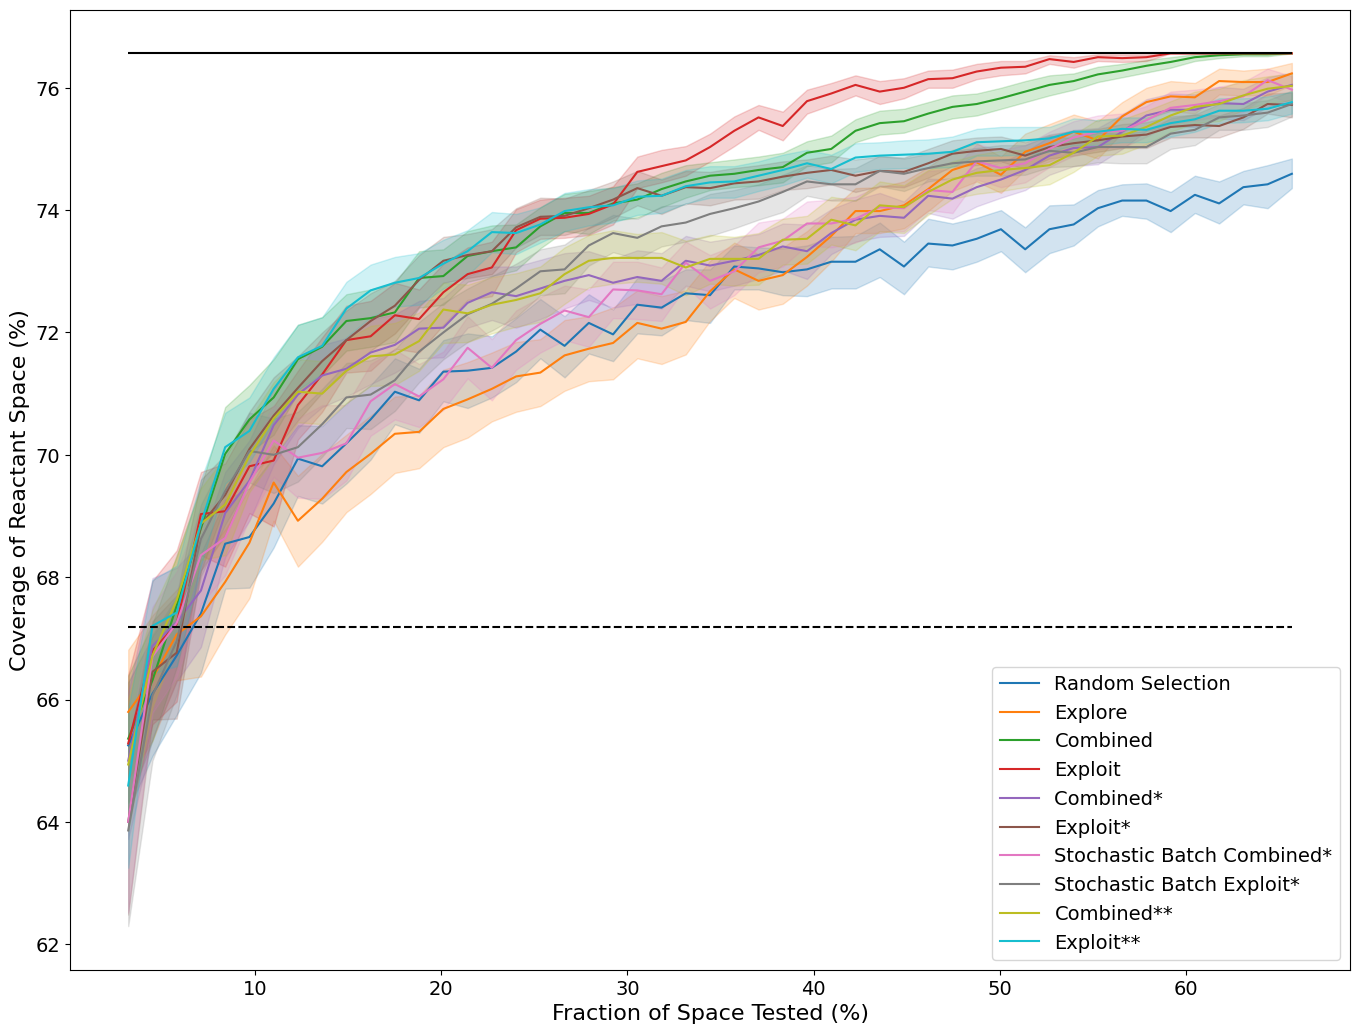

In [15]:
cols = plot_learner_metrics(aryl_scope, ['metrics/aryl-scope-ligand/2024-09-23_21:18:56_778883/metrics_2024-09-23_21:18:56_778883.pkl',
                   'metrics/aryl-scope-ligand/2024-09-27_13:45:47_691362/metrics_2024-09-27_13:45:47_691362.pkl',
                   'metrics/aryl-scope-ligand/2024-10-28_12:10:19_069885/metrics_2024-10-28_12:10:19_069885.pkl',
 'metrics/aryl-scope-ligand/2024-10-28_12:10:19_070025/metrics_2024-10-28_12:10:19_070025.pkl',
 'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066860/metrics_2024-09-23_21:20:37_066860.pkl',
 'metrics/aryl-scope-ligand/2024-09-27_13:52:58_711021/metrics_2024-09-27_13:52:58_711021.pkl',
 'metrics/aryl-scope-ligand/2024-10-06_22:54:53_154809/metrics_2024-10-06_22:54:53_154809.pkl',
 'metrics/aryl-scope-ligand/2024-10-06_22:54:53_153223/metrics_2024-10-06_22:54:53_153223.pkl',
 'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066857/metrics_2024-09-23_21:20:37_066857.pkl',
 'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066865/metrics_2024-09-23_21:20:37_066865.pkl'], ['Random Selection','Explore', 'Combined', 'Exploit', 
           'Combined* ', 'Exploit*','Stochastic Batch Combined*', 'Stochastic Batch Exploit*','Combined**', 'Exploit**'], ax=plt.axes([5,5,2,2]), title="", show_legend=True)

False
Axes(0.125,0.53;0.352273x0.35)
False
Axes(0.547727,0.53;0.352273x0.35)
False
Axes(0.125,0.11;0.352273x0.35)
False
Axes(0.547727,0.11;0.352273x0.35)


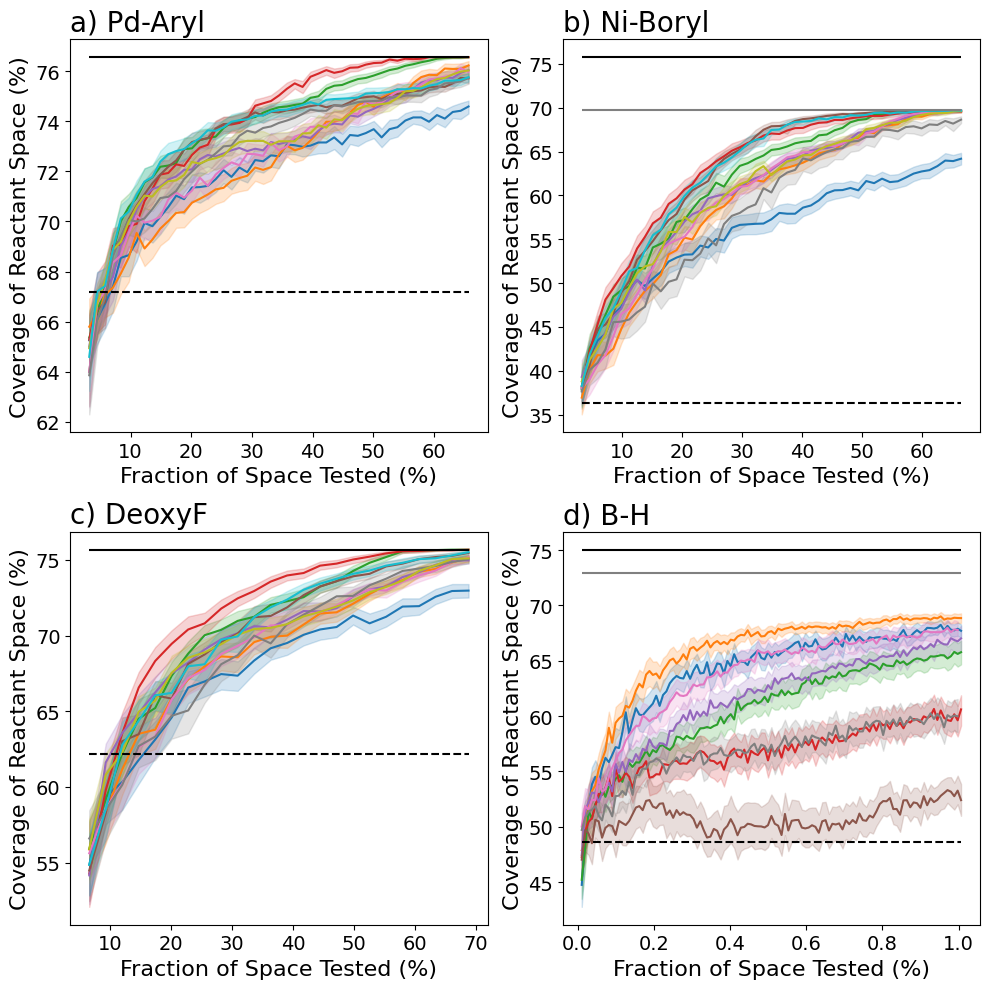

In [38]:
# RF final
plot_performance([aryl_scope, borylation, deoxy, buchwald_hartwig], 
                 [['metrics/aryl-scope-ligand/2024-09-23_21:18:56_778883/metrics_2024-09-23_21:18:56_778883.pkl',
                   'metrics/aryl-scope-ligand/2024-09-27_13:45:47_691362/metrics_2024-09-27_13:45:47_691362.pkl',
                   'metrics/aryl-scope-ligand/2024-10-28_12:10:19_069885/metrics_2024-10-28_12:10:19_069885.pkl',
 'metrics/aryl-scope-ligand/2024-10-28_12:10:19_070025/metrics_2024-10-28_12:10:19_070025.pkl',
 'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066860/metrics_2024-09-23_21:20:37_066860.pkl',
 'metrics/aryl-scope-ligand/2024-09-27_13:52:58_711021/metrics_2024-09-27_13:52:58_711021.pkl',
 'metrics/aryl-scope-ligand/2024-10-06_22:54:53_154809/metrics_2024-10-06_22:54:53_154809.pkl',
 'metrics/aryl-scope-ligand/2024-10-06_22:54:53_153223/metrics_2024-10-06_22:54:53_153223.pkl',
 'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066857/metrics_2024-09-23_21:20:37_066857.pkl',
 'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066865/metrics_2024-09-23_21:20:37_066865.pkl'
 ],
                      [
 # size 4
 'metrics/borylation/2024-09-27_15:47:20_799647/metrics_2024-09-27_15:47:20_799647.pkl',
                      'metrics/borylation/2024-09-27_15:47:20_700576/metrics_2024-09-27_15:47:20_700576.pkl',
                      'metrics/borylation/2024-10-28_12:21:12_702936/metrics_2024-10-28_12:21:12_702936.pkl',
                      'metrics/borylation/2024-10-28_12:21:12_702238/metrics_2024-10-28_12:21:12_702238.pkl',
                      'metrics/borylation/2024-09-27_15:47:20_753759/metrics_2024-09-27_15:47:20_753759.pkl',
                      'metrics/borylation/2024-09-27_15:47:20_670141/metrics_2024-09-27_15:47:20_670141.pkl',
                      'metrics/borylation/2024-10-06_22:54:53_134425/metrics_2024-10-06_22:54:53_134425.pkl',
                      'metrics/borylation/2024-10-06_22:54:53_133695/metrics_2024-10-06_22:54:53_133695.pkl',
                      'metrics/borylation/2024-09-27_RF_learner=1_batch=20/metrics_.pkl',
                      'metrics/borylation/2024-09-27_RF_learner=2_batch=20/metrics_.pkl'
                       ],
                    ['metrics/deoxyf/2024-09-27_13:55:01_992846/metrics_2024-09-27_13:55:01_992846.pkl',
         'metrics/deoxyf/2024-09-27_13:45:47_522336/metrics_2024-09-27_13:45:47_522336.pkl',
         'metrics/deoxyf/2024-10-28_12:10:19_030468/metrics_2024-10-28_12:10:19_030468.pkl',
 'metrics/deoxyf/2024-10-28_12:10:19_030594/metrics_2024-10-28_12:10:19_030594.pkl',
 'metrics/deoxyf/2024-09-27_13:55:02_069909/metrics_2024-09-27_13:55:02_069909.pkl',
 'metrics/deoxyf/2024-09-27_13:55:02_330270/metrics_2024-09-27_13:55:02_330270.pkl',
 'metrics/deoxyf/2024-10-06_22:54:53_113573/metrics_2024-10-06_22:54:53_113573.pkl',
 'metrics/deoxyf/2024-10-06_22:54:53_114508/metrics_2024-10-06_22:54:53_114508.pkl',
 'metrics/deoxyf/2024-09-27_13:55:02_209680/metrics_2024-09-27_13:55:02_209680.pkl',
 'metrics/deoxyf/2024-09-27_13:55:02_228887/metrics_2024-09-27_13:55:02_228887.pkl'
 ],
                    ['metrics/buchwald-hartwig/2024-09-27_RF_learner=-1_batch=40/metrics_.pkl',
                     'metrics/buchwald-hartwig/2024-09-27_RF_learner=0_batch=40/metrics_.pkl',
                     'metrics/buchwald-hartwig/2024-10-28_RF_learner=8_batch=40/metrics_.pkl',
                     'metrics/buchwald-hartwig/2024-11-02_RF_learner=9_batch=40/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-10-09_RF_learner=6_batch=40/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-10-09_RF_learner=7_batch=40/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-10-26_RF_learner=6_batch=40_stochastic_cond_num=20/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-10-28_RF_learner=7_batch=40_stochastic_cond_num=20/metrics_.pkl'
                      
                      ]]
                    ,
                [['Random Selection','Explore', 
                  'Combined', 'Exploit', 
           'Combined* ', 'Exploit*','Stochastic Batch Combined*', 'Stochastic Batch Exploit*','Combined**', 'Exploit**'],
           ['Random Selection','Explore', 
                  'Combined', 'Exploit', 
           'Combined* ', 'Exploit*','Stochastic Batch Combined*', 'Stochastic Batch Exploit*','Combined**', 'Exploit**'
           ],
           ['Random Selection','Explore', 
                  'Combined', 'Exploit', 
           'Combined* ', 'Exploit*','Stochastic Batch Combined*', 'Stochastic Batch Exploit*','Combined**', 'Exploit**'], #, 
           ['Random Selection','Explore', 
                  'Combined', 'Exploit', 
           'Combined* ', 'Exploit*','Stochastic Batch Combined*', 'Stochastic Batch Exploit*']], 
           ['a) Pd-Aryl', 'b) Ni-Boryl', 'c) DeoxyF', 'd) B-H'],
           [cols,
            cols,
            cols,
            cols[:-2]],
            [None, 0.6969697, None, 0.7292], legend_ax=-1)

False
Axes(0.125,0.53;0.352273x0.35)
False
Axes(0.547727,0.53;0.352273x0.35)
False
Axes(0.125,0.11;0.352273x0.35)
False
Axes(0.547727,0.11;0.352273x0.35)


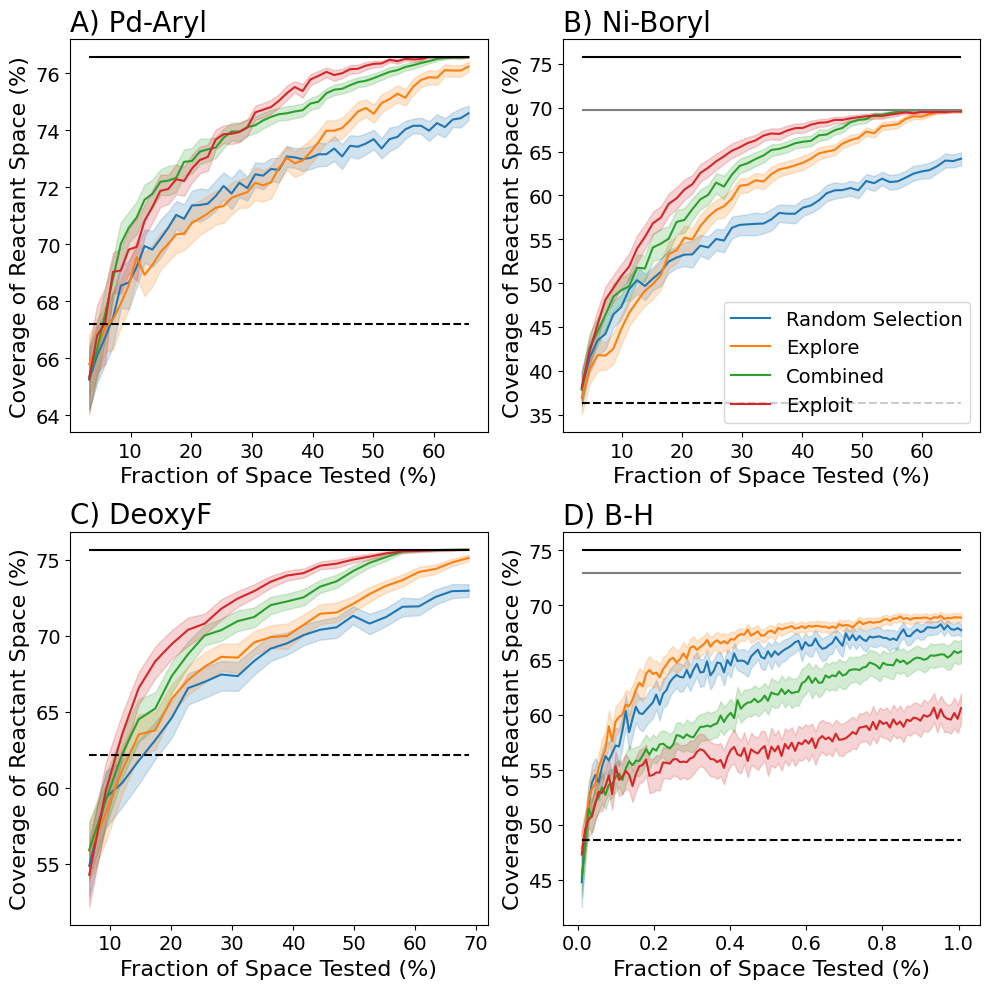

In [37]:
# RF final
plot_performance([aryl_scope, borylation, deoxy, buchwald_hartwig], 
                 [['metrics/aryl-scope-ligand/2024-09-23_21:18:56_778883/metrics_2024-09-23_21:18:56_778883.pkl',
                   'metrics/aryl-scope-ligand/2024-09-27_13:45:47_691362/metrics_2024-09-27_13:45:47_691362.pkl',
'metrics/aryl-scope-ligand/2024-10-28_12:10:19_069885/metrics_2024-10-28_12:10:19_069885.pkl',
 'metrics/aryl-scope-ligand/2024-10-28_12:10:19_070025/metrics_2024-10-28_12:10:19_070025.pkl'
 ],
                      [
 # size 4
 'metrics/borylation/2024-09-27_15:47:20_799647/metrics_2024-09-27_15:47:20_799647.pkl',
                      'metrics/borylation/2024-09-27_15:47:20_700576/metrics_2024-09-27_15:47:20_700576.pkl',
                      'metrics/borylation/2024-10-28_12:21:12_702936/metrics_2024-10-28_12:21:12_702936.pkl',
                      'metrics/borylation/2024-10-28_12:21:12_702238/metrics_2024-10-28_12:21:12_702238.pkl'

                      ],
                    ['metrics/deoxyf/2024-09-27_13:55:01_992846/metrics_2024-09-27_13:55:01_992846.pkl',
         'metrics/deoxyf/2024-09-27_13:45:47_522336/metrics_2024-09-27_13:45:47_522336.pkl',
'metrics/deoxyf/2024-10-28_12:10:19_030468/metrics_2024-10-28_12:10:19_030468.pkl',
 'metrics/deoxyf/2024-10-28_12:10:19_030594/metrics_2024-10-28_12:10:19_030594.pkl'

 ],
                    ['metrics/buchwald-hartwig/2024-09-27_RF_learner=-1_batch=40/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-09-27_RF_learner=0_batch=40/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-10-28_RF_learner=8_batch=40/metrics_.pkl',
                      'metrics/buchwald-hartwig/2024-11-02_RF_learner=9_batch=40/metrics_.pkl'

                      ]]
                    ,
                [['Random Selection','Explore', 
           'Combined', 'Exploit'],
           [
               'Random Selection','Explore', 
           'Combined', 'Exploit' 
           ],
           ['Random Selection','Explore', 
            'Combined', 'Exploit'], #, 
           ['Random Selection','Explore', 'Combined', 'Exploit']], 
           ['A) Pd-Aryl', 'B) Ni-Boryl', 'C) DeoxyF', 'D) B-H'],
           [cols[:4],
            cols[:4],
            cols[:4],
            cols[:4]],
            [None, 0.6969697, None, 0.7292], legend_ax=1)

False
Axes(0.125,0.53;0.352273x0.35)
False
Axes(0.547727,0.53;0.352273x0.35)
False
Axes(0.125,0.11;0.352273x0.35)
False
Axes(0.547727,0.11;0.352273x0.35)


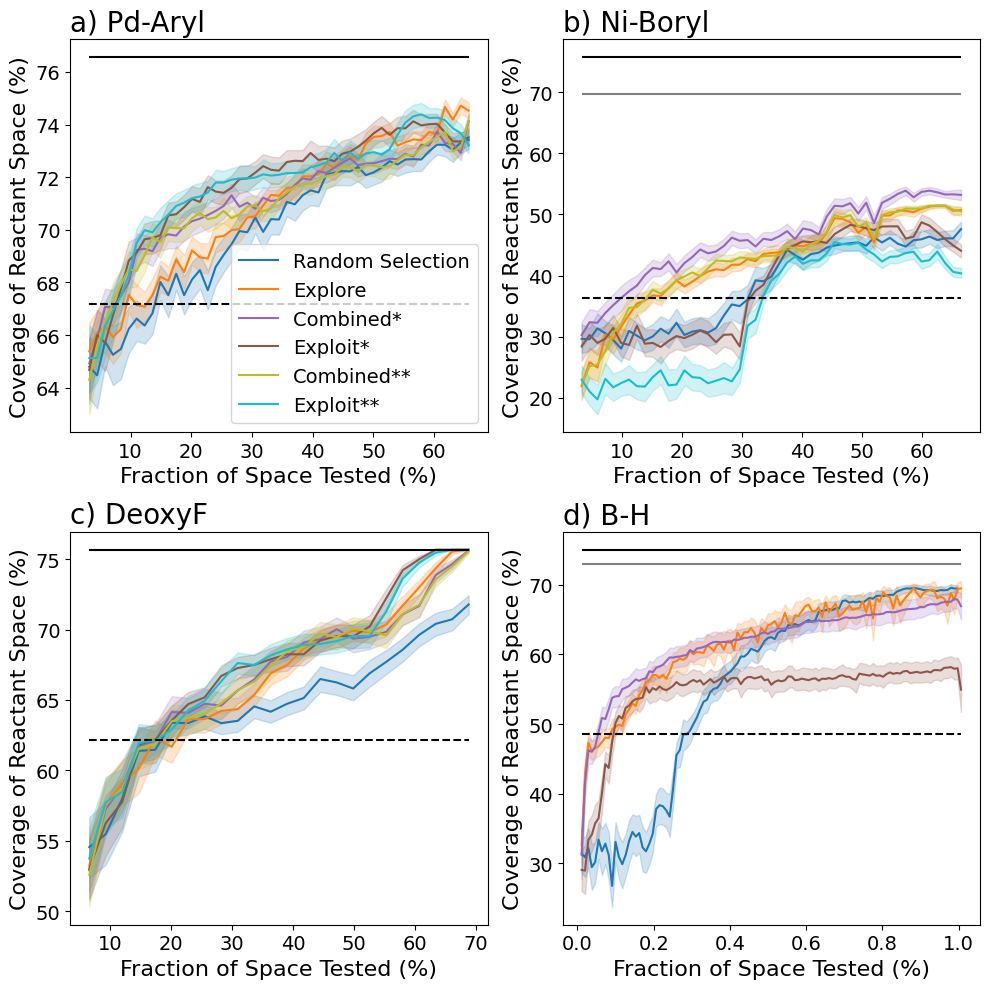

In [41]:
# GPC final
plot_performance([aryl_scope, borylation, deoxy, buchwald_hartwig], 
                 [['metrics/aryl-scope-ligand/2024-09-24_23:11:47_847244/metrics_2024-09-24_23:11:47_847244.pkl',
                   'metrics/aryl-scope-ligand/2024-10-28_GP_learner=0_batch=20/metrics_2024-10-28_GP_learner=0_batch=20.pkl',
 'metrics/aryl-scope-ligand/2024-09-24_23:11:47_942239/metrics_2024-09-24_23:11:47_942239.pkl',
 'metrics/aryl-scope-ligand/2024-09-24_23:11:47_990142/metrics_2024-09-24_23:11:47_990142.pkl',
 'metrics/aryl-scope-ligand/2024-09-24_23:11:47_828651/metrics_2024-09-24_23:11:47_828651.pkl',
 'metrics/aryl-scope-ligand/2024-09-24_23:11:48_018976/metrics_2024-09-24_23:11:48_018976.pkl'],
                      ['metrics/borylation/2024-09-24_23:11:48_093565/metrics_2024-09-24_23:11:48_093565.pkl',
                        'metrics/borylation/2024-09-27_13:45:47_792209/metrics_2024-09-27_13:45:47_792209.pkl',
 'metrics/borylation/2024-09-25_00:08:57_342956/metrics_2024-09-25_00:08:57_342956.pkl',
 'metrics/borylation/2024-09-25_00:09:58_531637/metrics_2024-09-25_00:09:58_531637.pkl',
 'metrics/borylation/2024-09-26_12:42:51_713858/metrics_2024-09-26_12:42:51_713858.pkl',
                      'metrics/borylation/2024-09-26_12:42:51_713192/metrics_2024-09-26_12:42:51_713192.pkl'],
                    ['metrics/deoxyf/2024-09-24_23:11:47_857737/metrics_2024-09-24_23:11:47_857737.pkl',
                     'metrics/deoxyf/2024-09-27_13:45:47_522572/metrics_2024-09-27_13:45:47_522572.pkl',
 'metrics/deoxyf/2024-09-24_23:11:47_620814/metrics_2024-09-24_23:11:47_620814.pkl',
 'metrics/deoxyf/2024-09-24_23:11:47_683473/metrics_2024-09-24_23:11:47_683473.pkl',
 'metrics/deoxyf/2024-09-24_23:11:46_030555/metrics_2024-09-24_23:11:46_030555.pkl',
 'metrics/deoxyf/2024-09-24_23:11:46_110894/metrics_2024-09-24_23:11:46_110894.pkl'],
                    ['metrics/buchwald-hartwig/2024-10-25_GP_learner=-1_batch=40/metrics_.pkl',
                     'metrics/buchwald-hartwig/2024-10-25_GP_learner=0_batch=40/metrics_.pkl',
                     'metrics/buchwald-hartwig/2024-10-25_GP_learner=6_batch=40/metrics_.pkl',
                     'metrics/buchwald-hartwig/2024-10-25_GP_learner=7_batch=40/metrics_.pkl'
                      ]],
                [['Random Selection','Explore', 
           'Combined* ', 'Exploit*','Combined**', 'Exploit**'],
           ['Random Selection','Explore', 
           'Combined* ', 'Exploit*','Combined**', 'Exploit**'],
           ['Random Selection','Explore', 
           'Combined* ', 'Exploit*','Combined**', 'Exploit**'], #, 
           ['Random Selection','Explore', 
           'Combined* ', 'Exploit*']], 
           ['a) Pd-Aryl', 'b) Ni-Boryl', 'c) DeoxyF', 'd) B-H'],
           [cols[:2]+cols[4:6]+cols[8:],
            cols[:2]+cols[4:6]+cols[8:],
            cols[:2]+cols[4:6]+cols[8:],
            cols[:2]+cols[4:6]],
            [None, 0.6969697, None, 0.7292])

In [25]:
def create_batch_df(chemical_space:ChemicalSpace, batch_dict:dict, learner:int)->pd.DataFrame:
    df = pd.DataFrame(columns=["Fraction of Space Tested", 'Predicted Coverage', 'Actual Coverage', 'Accuracy', 'Precision', 'Recall', 'Batch Size'])
    m = {}
    for batch_size in batch_dict.keys():
        metric_file = batch_dict[batch_size][learner]
        with open(metric_file, 'rb') as f:
            try:
                m = pickle.load(f)
            except:
                print(metric_file)
        conf_file = metric_file.replace('metrics_', 'config_')
        with open(conf_file, 'rb') as f:
            try:
                conf = pickle.load(f)
            except:
                print(conf_file)
            yield_cutoff = conf['cutoff']
            evals = np.divide([49 + i*batch_size for i in range(0, 1 + conf['max_experiments']//batch_size)], np.prod(chemical_space.shape)) *100
        for j, metric in m.items():
            coverages = np.array(metric['coverages'])
            best_sets = metric['best_sets']
            best = coverages[:,0]
            if np.any(best > 1):
                best = best/np.prod(chemical_space.shape[chemical_space.conditions_dim:])
            best_pred_sets = [s[0] for s in best_sets]
            best_actual = [chemical_space.yield_surface.count_coverage(set, yield_cutoff) * 100 for set in best_pred_sets]
            iter_df = pd.DataFrame({'Fraction of Space Tested':evals[:len(best)], 'Predicted Coverage':best, 'Actual Coverage': best_actual, 'Accuracy':metric['accuracy'], 'Precision':metric['precision'], 'Recall':metric['recall'], 
                                'Batch Size': [batch_size] * len(best)})
            iter_df.fillna(0, inplace=True)
            if df.empty:
                df  = iter_df
            else:
                df = pd.concat([df, iter_df])
    return df




def plot_batch_performance(chemical_space:ChemicalSpace, batch_dict:dict, titles= ['Random Selection', 'Explore', 'Explore-Exploit*', 'Exploit*'], max_possible_set_cover=None, yield_cutoff=.75)->None:
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True) #(13, 10)
    axs = axs.flatten()

    for i in range(4):
        df = create_batch_df(chemical_space, batch_dict, i)
        g = sns.lineplot(data=df, x='Fraction of Space Tested', y='Actual Coverage', hue='Batch Size', hue_order=[1, 10, 20, 40, 80, 160], palette='colorblind', ax=axs[i])
        g.hlines(y=[chemical_space.max_possible_coverage(yield_cutoff)*100], xmin=df['Fraction of Space Tested'].min(), xmax=df['Fraction of Space Tested'].max(), colors='black', linestyles='solid')
        if max_possible_set_cover:
            g.hlines(y=[max_possible_set_cover*100], xmin=df['Fraction of Space Tested'].min(), xmax=df['Fraction of Space Tested'].max(), colors='gray', linestyles='solid')
        g.hlines(y=[chemical_space.best_condition_sets(yield_cutoff, 1, 1)[0]['coverage']*100], xmin=df['Fraction of Space Tested'].min(), xmax=df['Fraction of Space Tested'].max(), colors='black', linestyles='dashed')

        axs[i].set_xlabel('Fraction of Space Tested (%)', fontsize=16)
        axs[i].set_ylabel('Coverage of Reactant Space (%)', fontsize=16)
        ax_handles, ax_labels = axs[i].get_legend_handles_labels()

        axs[i].legend(handles=ax_handles, labels=ax_labels, fontsize=14).set_visible((i==0))
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_title(titles[i], loc='left', fontsize=20)

    plt.tight_layout()
    

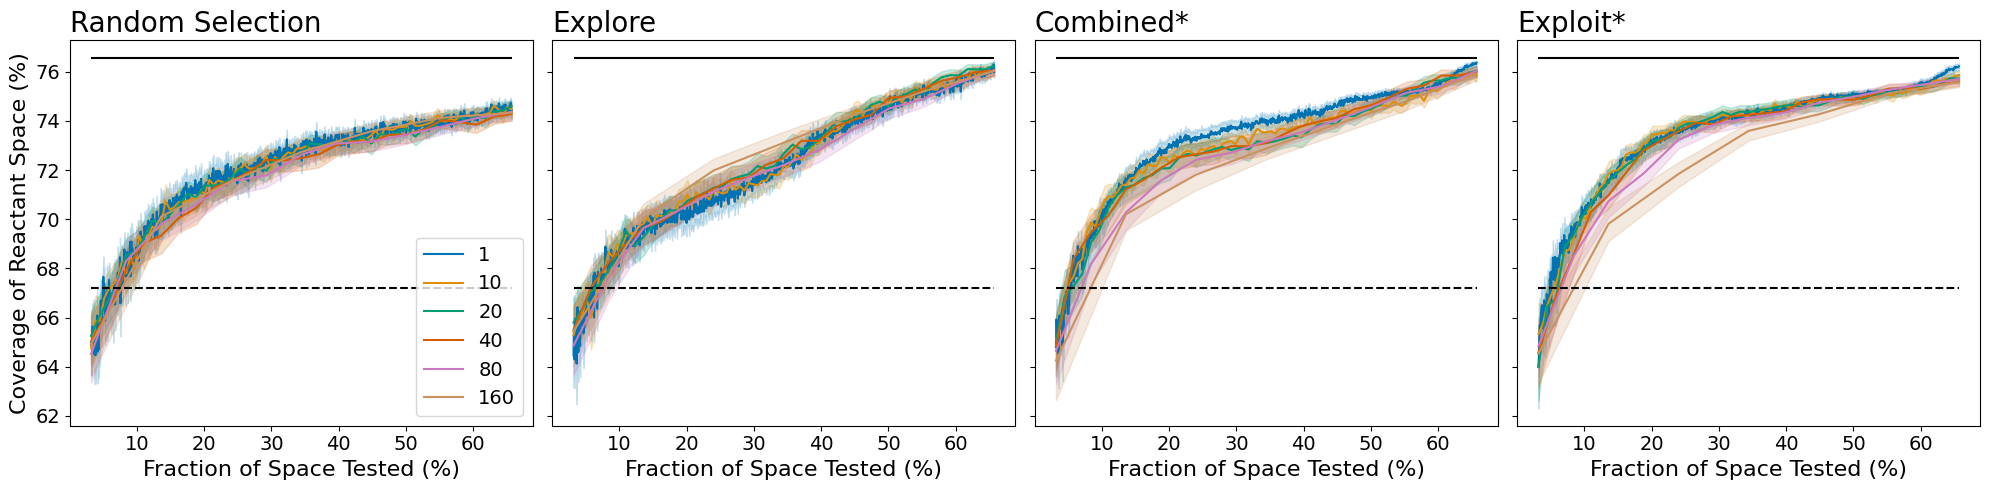

In [33]:
aryl_scope_batch = {1: ['metrics/aryl-scope-ligand/2024-10-07_06:14:32_478466/metrics_2024-10-07_06:14:32_478466.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_13:07:12_681075/metrics_2024-10-07_13:07:12_681075.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_16:06:19_401971/metrics_2024-10-07_16:06:19_401971.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_16:06:19_405964/metrics_2024-10-07_16:06:19_405964.pkl'],
 10: ['metrics/aryl-scope-ligand/11_06_RF_learner=-1_batch=10/metrics_.pkl',
  'metrics/aryl-scope-ligand/2024-10-08_01:17:38_821939/metrics_2024-10-08_01:17:38_821939.pkl',
  'metrics/aryl-scope-ligand/2024-10-08_02:01:34_280861/metrics_2024-10-08_02:01:34_280861.pkl',
  'metrics/aryl-scope-ligand/2024-10-08_02:44:18_115187/metrics_2024-10-08_02:44:18_115187.pkl'],
 20: ['metrics/aryl-scope-ligand/2024-09-23_21:18:56_778883/metrics_2024-09-23_21:18:56_778883.pkl',
  'metrics/aryl-scope-ligand/2024-09-27_13:45:47_691362/metrics_2024-09-27_13:45:47_691362.pkl',
  'metrics/aryl-scope-ligand/2024-09-23_21:20:37_066860/metrics_2024-09-23_21:20:37_066860.pkl',
  'metrics/aryl-scope-ligand/2024-09-27_13:52:58_711021/metrics_2024-09-27_13:52:58_711021.pkl'],
 40: ['metrics/aryl-scope-ligand/2024-10-07_12:45:19_807418/metrics_2024-10-07_12:45:19_807418.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_12:56:42_020083/metrics_2024-10-07_12:56:42_020083.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_13:01:47_055667/metrics_2024-10-07_13:01:47_055667.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_13:08:14_424070/metrics_2024-10-07_13:08:14_424070.pkl'],
 80: ['metrics/aryl-scope-ligand/2024-10-08_05:39:40_738279/metrics_2024-10-08_05:39:40_738279.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_14:16:14_882692/metrics_2024-10-07_14:16:14_882692.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_14:21:14_603283/metrics_2024-10-07_14:21:14_603283.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_14:23:17_527790/metrics_2024-10-07_14:23:17_527790.pkl'],
 160: ['metrics/aryl-scope-ligand/2024-10-07_14:57:04_292443/metrics_2024-10-07_14:57:04_292443.pkl',
  'metrics/aryl-scope-ligand/2024-10-08_06:07:01_729169/metrics_2024-10-08_06:07:01_729169.pkl',
  'metrics/aryl-scope-ligand/2024-10-07_15:00:32_841212/metrics_2024-10-07_15:00:32_841212.pkl',
  'metrics/aryl-scope-ligand/2024-10-08_06:15:51_794319/metrics_2024-10-08_06:15:51_794319.pkl']}

plot_batch_performance(aryl_scope, aryl_scope_batch, ['Random Selection', 'Explore', 'Combined*', 'Exploit*'], yield_cutoff=21.66)

In [27]:
deoxy_batch = {1: ['metrics/deoxyf/2024-10-06_22:54:53_113745/metrics_2024-10-06_22:54:53_113745.pkl',
  'metrics/deoxyf/2024-10-06_23:00:43_837547/metrics_2024-10-06_23:00:43_837547.pkl',
  'metrics/deoxyf/2024-10-07_20:22:03_524883/metrics_2024-10-07_20:22:03_524883.pkl',
  'metrics/deoxyf/2024-10-07_20:34:59_404549/metrics_2024-10-07_20:34:59_404549.pkl'],
 10: ['metrics/deoxyf/2024-10-08_03:08:43_584463/metrics_2024-10-08_03:08:43_584463.pkl',
  'metrics/deoxyf/2024-10-07_11:18:41_078294/metrics_2024-10-07_11:18:41_078294.pkl',
  'metrics/deoxyf/2024-10-08_03:14:28_573573/metrics_2024-10-08_03:14:28_573573.pkl',
  'metrics/deoxyf/2024-10-08_03:24:37_377870/metrics_2024-10-08_03:24:37_377870.pkl'],
 20: ['metrics/deoxyf/2024-09-27_13:55:01_992846/metrics_2024-09-27_13:55:01_992846.pkl',
  'metrics/deoxyf/2024-09-27_13:45:47_522336/metrics_2024-09-27_13:45:47_522336.pkl',
  'metrics/deoxyf/2024-09-27_13:55:02_069909/metrics_2024-09-27_13:55:02_069909.pkl',
  'metrics/deoxyf/2024-09-27_13:55:02_330270/metrics_2024-09-27_13:55:02_330270.pkl'],
 40: ['metrics/deoxyf/2024-10-07_13:21:48_052324/metrics_2024-10-07_13:21:48_052324.pkl',
  'metrics/deoxyf/2024-10-08_05:06:57_560221/metrics_2024-10-08_05:06:57_560221.pkl',
  'metrics/deoxyf/2024-10-08_05:11:30_423822/metrics_2024-10-08_05:11:30_423822.pkl',
  'metrics/deoxyf/2024-10-07_13:27:25_681467/metrics_2024-10-07_13:27:25_681467.pkl'],
 80: ['metrics/deoxyf/2024-10-08_05:46:06_685066/metrics_2024-10-08_05:46:06_685066.pkl',
  'metrics/deoxyf/2024-10-07_14:29:37_511290/metrics_2024-10-07_14:29:37_511290.pkl',
  'metrics/deoxyf/2024-10-07_14:31:35_225982/metrics_2024-10-07_14:31:35_225982.pkl',
  'metrics/deoxyf/2024-10-08_05:54:44_208956/metrics_2024-10-08_05:54:44_208956.pkl'],
 160: ['metrics/deoxyf/2024-10-08_06:17:10_626143/metrics_2024-10-08_06:17:10_626143.pkl',
  'metrics/deoxyf/2024-10-07_15:05:47_522131/metrics_2024-10-07_15:05:47_522131.pkl',
  'metrics/deoxyf/2024-10-07_15:06:18_373779/metrics_2024-10-07_15:06:18_373779.pkl',
  'metrics/deoxyf/2024-10-08_06:18:41_428798/metrics_2024-10-08_06:18:41_428798.pkl']}

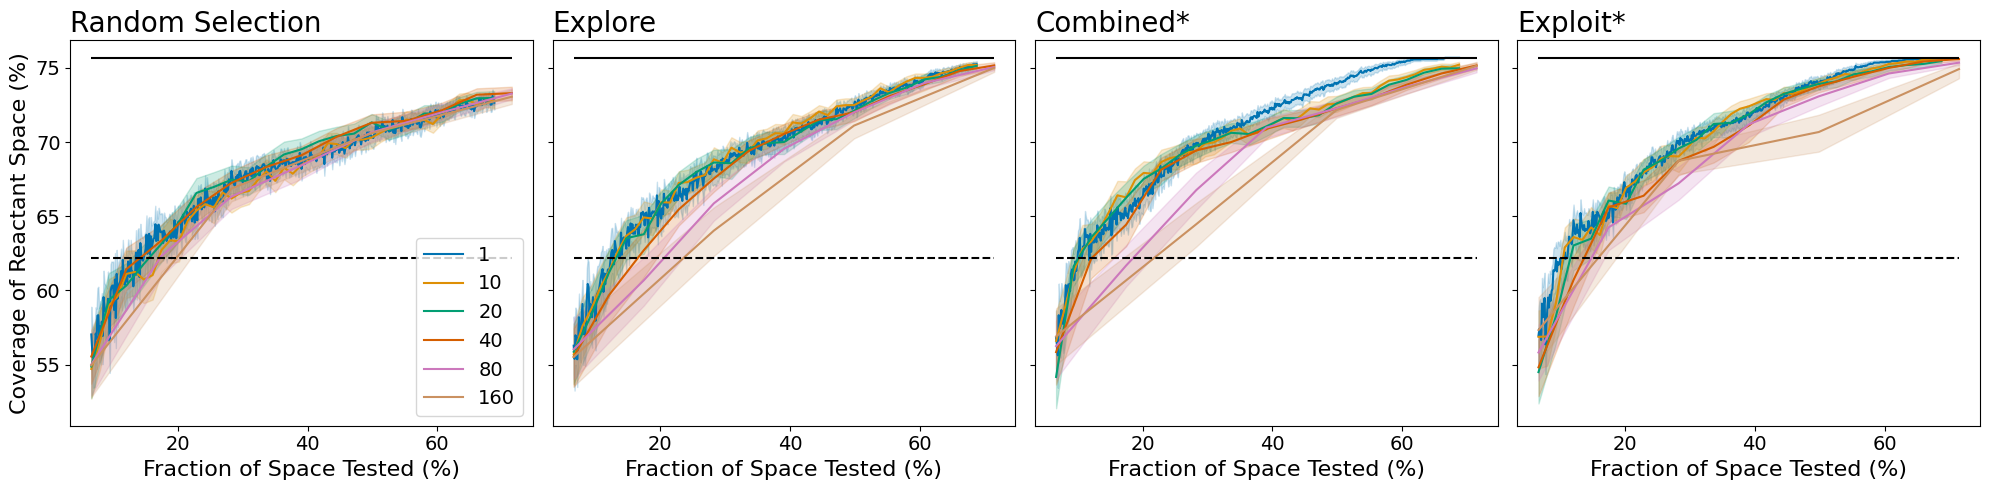

In [28]:
plot_batch_performance(deoxy, deoxy_batch, ['Random Selection', 'Explore', 'Combined*', 'Exploit*'], yield_cutoff=50)

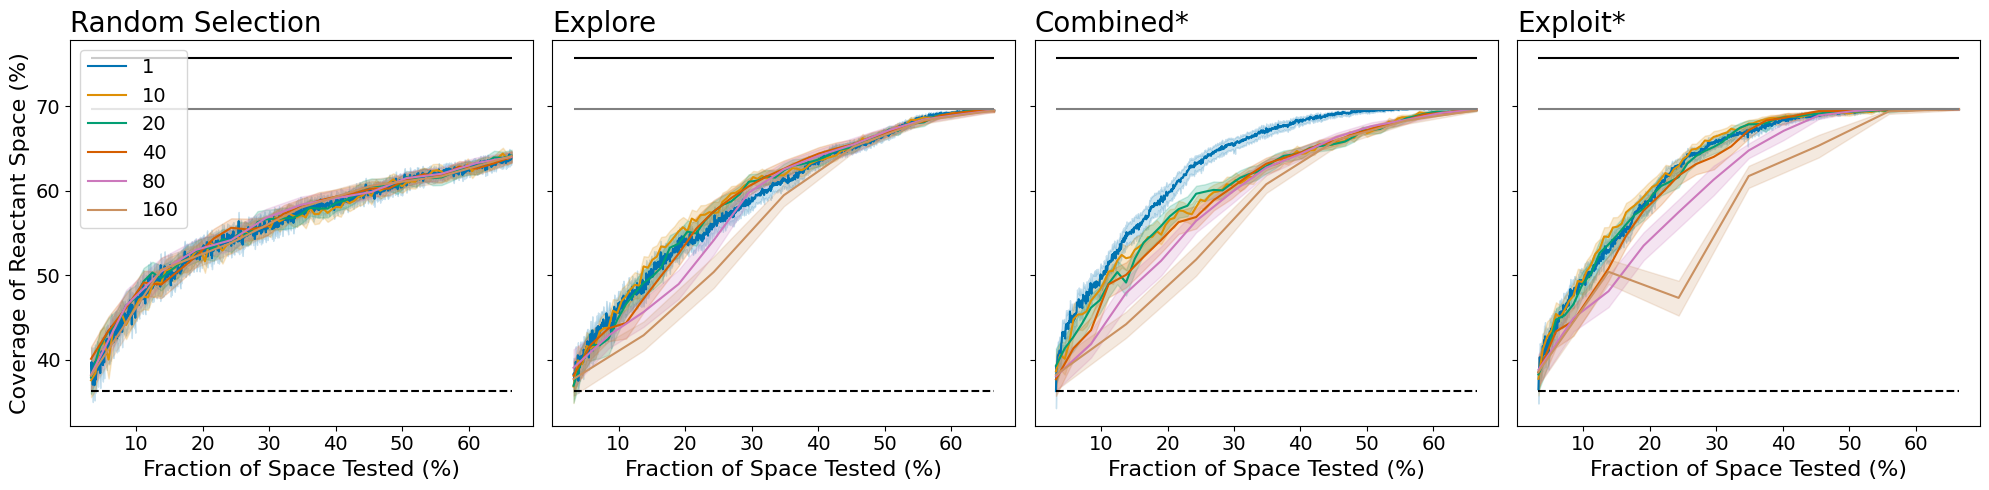

In [31]:
boryl_batch = {
    1: ['metrics/borylation/2024-10-10_RF_learner=-1_batch=1/metrics_2024-10-10_RF_learner=-1_batch=1.pkl',
  'metrics/borylation/2024-10-10_RF_learner=0_batch=1/metrics_.pkl',
  'metrics/borylation/2024-09-27_RF_learner=6_batch=1/metrics_.pkl',
  'metrics/borylation/2024-10-10_RF_learner=7_batch=1/metrics_.pkl'],
 10: ['metrics/borylation/2024-10-07_20:36:39_770456/metrics_2024-10-07_20:36:39_770456.pkl',
  'metrics/borylation/2024-10-08_00:05:15_288482/metrics_2024-10-08_00:05:15_288482.pkl',
  'metrics/borylation/2024-10-08_00:31:32_433149/metrics_2024-10-08_00:31:32_433149.pkl',
  'metrics/borylation/2024-10-08_00:36:57_347954/metrics_2024-10-08_00:36:57_347954.pkl'],
 20: ['metrics/borylation/2024-09-27_15:47:20_799647/metrics_2024-09-27_15:47:20_799647.pkl',
  'metrics/borylation/2024-09-27_15:47:20_700576/metrics_2024-09-27_15:47:20_700576.pkl',
  'metrics/borylation/2024-09-27_15:47:20_753759/metrics_2024-09-27_15:47:20_753759.pkl',
  'metrics/borylation/2024-09-27_15:47:20_670141/metrics_2024-09-27_15:47:20_670141.pkl'],
 40: ['metrics/borylation/2024-10-08_03:24:54_538734/metrics_2024-10-08_03:24:54_538734.pkl',
  'metrics/borylation/2024-10-08_03:36:35_461876/metrics_2024-10-08_03:36:35_461876.pkl',
  'metrics/borylation/2024-10-08_03:46:43_692767/metrics_2024-10-08_03:46:43_692767.pkl',
  'metrics/borylation/2024-10-08_03:58:58_434222/metrics_2024-10-08_03:58:58_434222.pkl'],
 80: ['metrics/borylation/2024-10-08_05:17:45_616058/metrics_2024-10-08_05:17:45_616058.pkl',
  'metrics/borylation/2024-10-08_05:19:38_654450/metrics_2024-10-08_05:19:38_654450.pkl',
  'metrics/borylation/2024-10-07_13:34:12_363648/metrics_2024-10-07_13:34:12_363648.pkl',
  'metrics/borylation/2024-10-07_13:34:12_362752/metrics_2024-10-07_13:34:12_362752.pkl'],
 160: ['metrics/borylation/2024-10-07_14:32:33_348650/metrics_2024-10-07_14:32:33_348650.pkl',
  'metrics/borylation/2024-10-08_05:54:55_578232/metrics_2024-10-08_05:54:55_578232.pkl',
  'metrics/borylation/2024-10-08_05:58:28_476558/metrics_2024-10-08_05:58:28_476558.pkl',
  'metrics/borylation/2024-10-07_14:36:26_314941/metrics_2024-10-07_14:36:26_314941.pkl']}

plot_batch_performance(borylation, boryl_batch, ['Random Selection', 'Explore', 'Combined*', 'Exploit*'], yield_cutoff=77.24, max_possible_set_cover=0.6969697)